In [24]:
import numpy as np
import sklearn
import json
import os
import matplotlib.pyplot as plt

from scipy.special import softmax
from sklearn import metrics
from sklearn import preprocessing

In [25]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


In [76]:
CUR_DIR = os.getcwd()
DIR_VALID = os.path.join(CUR_DIR, "valid_outputs")
output_files = ["mnist_exp_at_seed941.json", "mnist_no_at_seed941.json", "mnist_ensemble_new.json"]
outputs = {}
for file_name in output_files:
    file_path = os.path.join(DIR_VALID, file_name)
    with open(file_path, 'r') as f:
        outputs[file_name] = json.load(f)

In [27]:
y_label_path = os.path.join(DIR_VALID, "valid_y_labels.json")
with open(y_label_path, 'r') as f:
    y_labels = json.load(f)

In [99]:
CUR_DIR = os.getcwd()
DIR_TEST = os.path.join(CUR_DIR, "test_outputs")
test_output_files = ["no-at-single-logits.json", "PGD-single-logits.json", "PGD-single.json", 
               "PGD-ensemble-3.json", "PGD-ensemble-5.json", "PGD-ensemble-7.json"]
test_outputs = {}
for file_name in test_output_files:
    file_path = os.path.join(DIR_TEST, file_name)
    with open(file_path, 'r') as f:
        test_outputs[file_name] = json.load(f)

In [116]:
CUR_DIR = os.getcwd()
DIR_TEST = os.path.join(CUR_DIR, "transform_test_data")
test_output_files = ["4transforms.json", "ensemble_single_trans.json", "normal.json", "uniform.json"]
for file_name in test_output_files:
    file_path = os.path.join(DIR_TEST, file_name)
    with open(file_path, 'r') as f:
        test_outputs[file_name] = json.load(f)

In [117]:
test_outputs.keys()

dict_keys(['no-at-single-logits.json', 'PGD-single-logits.json', 'PGD-single.json', 'PGD-ensemble-3.json', 'PGD-ensemble-5.json', 'PGD-ensemble-7.json', '4transforms.json', 'ensemble_single_trans.json', 'normal.json', 'uniform.json'])

In [70]:
y_test_path = os.path.join(DIR_TEST, "y_test.json")
with open(y_test_path, 'r') as f:
    y_test = json.load(f)

In [79]:
def split_correct(logits, temperature, y_test, ensemble=False):
    np_logits = np.array(logits)
    np_softmax = softmax(np_logits/temperature, axis=1)
    if ensemble:
        np_softmax = np.mean(np_softmax, axis=0)
    y_test = np.array(y_test)

    data = {}
    if ensemble:
        correct_logits = np_logits[:, np_softmax.argmax(axis=1)==y_test]
    else:
        correct_logits = np_logits[np_softmax.argmax(axis=1)==y_test]
    correct_targets = y_test[np_softmax.argmax(axis=1)==y_test]
    data['correct_logits'] = list(correct_logits)
    data['correct_targets'] = list(correct_targets)
    
    if ensemble:
        incorrect_logits = np_logits[:, np_softmax.argmax(axis=1)!=y_test]
    else:
        incorrect_logits = np_logits[np_softmax.argmax(axis=1)!=y_test]
    incorrect_targets = y_test[np_softmax.argmax(axis=1)!=y_test]
    data['incorrect_logits'] = list(incorrect_logits)
    data['incorrect_targets'] = list(incorrect_targets)
    return data

In [33]:
def get_max_softmax(preds):
    return preds.max(axis=1)

In [34]:
def get_ll(preds):
    return np.mean(np.log(1e-12 + preds), axis=1)

In [35]:
def get_shannon_entropy(preds):
    preds[preds==0] = 1
    entropy = -np.sum(preds * np.log2(preds), axis=1)
    return list(entropy)

In [109]:
# Consider adv as positive, clean as negative
def temperature_roc(logits, temperature, y_labels, metric, ensemble=False):
    np_logits = np.array(logits)
    print(np_logits.shape)
    if ensemble:
        np_softmax_ensemble = softmax(np_logits/temperature, axis=2)
        np_softmax = np.mean(np_softmax_ensemble, axis=0)
    else:
        np_softmax = softmax(np_logits/temperature, axis=1)
    np_y_labels = np.array(y_labels)
    
    # Want the higher the confidence score, the more likely it's positive
    # In our case, ideally low max_softmax, low log-likelihood, high entropy suggests adv
    if metric == "max softmax":
        max_softmax = get_max_softmax(np_softmax)
        fpr, tpr, thresholds = metrics.roc_curve(np_y_labels, -max_softmax)
        auc = metrics.auc(fpr, tpr)
    if metric == "ll":
        ll = get_ll(np_softmax)
#         print(np.mean(ll))
        fpr, tpr, thresholds = metrics.roc_curve(np_y_labels, -ll)
        auc = metrics.auc(fpr, tpr)
    if metric == "entropy":
        entropy = get_shannon_entropy(np_softmax)
        fpr, tpr, thresholds = metrics.roc_curve(np_y_labels, entropy)
        auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, auc

In [37]:
def best_temperature(logits, temperature_range, y_labels, metric, ensemble=False):
    max_auc = 0
    best_temperature = 1
    for t in temperature_range:
        fpr, tpr, thresholds, cur_auc = temperature_roc(logits, t, y_labels, metric, ensemble)
        if cur_auc > max_auc:
            max_auc = cur_auc
            best_temperature = t
    return best_temperature

In [38]:
def store_temperatures_by_model(model, ensemble=False):
    BEST_T_SM[model] = best_temperature(INPUTS[model], np.arange(0.1, 10, 0.1), LABELS[model], "max softmax", ensemble)
    BEST_T_LL[model] = best_temperature(INPUTS[model], np.arange(0.1, 10, 0.1), LABELS[model], "ll", ensemble)
    BEST_T_ENT[model] = best_temperature(INPUTS[model], np.arange(0.1, 10, 0.1), LABELS[model], "entropy", ensemble)
    print("best temperature for max softmax: {}".format(BEST_T_SM[model]))
    print("best temperature for log likelihood: {}".format(BEST_T_LL[model]))
    print("best temperature for entropy: {}".format(BEST_T_ENT[model]))

In [39]:
def calc_plot_roc(model, ensemble=False):
    fpr_max_sm, tpr_max_sm, thresholds_max_sm, auc_max_sm = temperature_roc(INPUTS[model], BEST_T_SM[model], LABELS[model], "max softmax", ensemble)
    fpr_ll, tpr_ll, thresholds_ll, auc_ll = temperature_roc(INPUTS[model], BEST_T_LL[model], LABELS[model], "ll", ensemble)
    fpr_entropy, tpr_entropy, thresholds_entropy, auc_entropy = temperature_roc(INPUTS[model], BEST_T_ENT[model], LABELS[model], "entropy", ensemble)

    plt.title('ROC Curve w/ best temperatures')
    plt.plot(fpr_max_sm, tpr_max_sm, 'b', label = 'Max SM AUC = %0.2f' % auc_max_sm, color='y')
    plt.plot(fpr_ll, tpr_ll, 'b', label = 'll AUC = %0.2f' % auc_ll, color='r')
    plt.plot(fpr_entropy, tpr_entropy, 'b', label = 'Entropy AUC = %0.2f' % auc_entropy, color='b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [40]:
INPUTS, LABELS, BEST_T_SM, BEST_T_LL, BEST_T_ENT = {}, {}, {}, {}, {}

## Correct and incorrect combined in clean/adv combined

In [41]:
INPUTS['single_no_at'] = np.concatenate([np.array(outputs["mnist_no_at_seed941.json"]['clean']), np.array(outputs["mnist_no_at_seed941.json"]['adv'])])
clean_y = np.zeros((np.array(outputs["mnist_no_at_seed941.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(outputs["mnist_no_at_seed941.json"]['adv']).shape[0], ))
LABELS['single_no_at'] = np.concatenate([clean_y, adv_y])

In [48]:
INPUTS['single_no_at_test'] = np.concatenate([np.array(test_outputs["no-at-single-logits.json"]['clean']), np.array(test_outputs["no-at-single-logits.json"]['adv'])])
clean_y = np.zeros((np.array(test_outputs["no-at-single-logits.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(test_outputs["no-at-single-logits.json"]['adv']).shape[0], ))
LABELS['single_no_at_test'] = np.concatenate([clean_y, adv_y])
BEST_T_SM['single_no_at_test'] = BEST_T_SM['single_no_at']
BEST_T_LL['single_no_at_test'] = BEST_T_LL['single_no_at']
BEST_T_ENT['single_no_at_test'] = BEST_T_ENT['single_no_at']

In [51]:
INPUTS['single_at'] = np.concatenate([np.array(outputs["mnist_exp_at_seed941.json"]['clean']), np.array(outputs["mnist_exp_at_seed941.json"]['adv'])])
clean_y = np.zeros((np.array(outputs["mnist_exp_at_seed941.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(outputs["mnist_exp_at_seed941.json"]['adv']).shape[0], ))
LABELS['single_at'] = np.concatenate([clean_y, adv_y])

In [53]:
INPUTS['single_at_test'] = np.concatenate([np.array(test_outputs["PGD-single-logits.json"]['clean']), np.array(test_outputs["PGD-single-logits.json"]['adv'])])
clean_y = np.zeros((np.array(test_outputs["PGD-single-logits.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(test_outputs["PGD-single-logits.json"]['adv']).shape[0], ))
LABELS['single_at_test'] = np.concatenate([clean_y, adv_y])
BEST_T_SM['single_at_test'] = BEST_T_SM['single_at']
BEST_T_LL['single_at_test'] = BEST_T_LL['single_at']
BEST_T_ENT['single_at_test'] = BEST_T_ENT['single_at']

In [83]:
INPUTS["4transforms.json"] = np.concatenate([np.array(test_outputs["4transforms.json"]['clean']), np.array(test_outputs["4transforms.json"]['adv'])])
clean_y = np.zeros((np.array(test_outputs["4transforms.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(test_outputs["4transforms.json"]['adv']).shape[0], ))
LABELS["4transforms.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["4transforms.json"] = BEST_T_SM['single_at']
BEST_T_LL["4transforms.json"] = BEST_T_LL['single_at']
BEST_T_ENT["4transforms.json"] = BEST_T_ENT['single_at']

In [91]:
INPUTS["normal.json"] = np.concatenate([np.array(test_outputs["normal.json"]['clean']), np.array(test_outputs["normal.json"]['adv'])])
clean_y = np.zeros((np.array(test_outputs["normal.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(test_outputs["normal.json"]['adv']).shape[0], ))
LABELS["normal.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["normal.json"] = BEST_T_SM['single_at']
BEST_T_LL["normal.json"] = BEST_T_LL['single_at']
BEST_T_ENT["normal.json"] = BEST_T_ENT['single_at']

In [92]:
INPUTS["uniform.json"] = np.concatenate([np.array(test_outputs["uniform.json"]['clean']), np.array(test_outputs["uniform.json"]['adv'])])
clean_y = np.zeros((np.array(test_outputs["uniform.json"]['clean']).shape[0], ))
adv_y = np.ones((np.array(test_outputs["uniform.json"]['adv']).shape[0], ))
LABELS["uniform.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["uniform.json"] = BEST_T_SM['single_at']
BEST_T_LL["uniform.json"] = BEST_T_LL['single_at']
BEST_T_ENT["uniform.json"] = BEST_T_ENT['single_at']

In [54]:
INPUTS['ensemble_at'] = np.concatenate([np.array(outputs["mnist_ensemble_new.json"]['clean']), np.array(outputs["mnist_ensemble_new.json"]['adv'])], axis=1)
clean_y = np.zeros((np.array(outputs["mnist_ensemble_new.json"]['clean']).shape[1], ))
adv_y = np.ones((np.array(outputs["mnist_ensemble_new.json"]['adv']).shape[1], ))
LABELS['ensemble_at'] = np.concatenate([clean_y, adv_y])

In [100]:
INPUTS["PGD-ensemble-3.json"] = np.concatenate([np.array(test_outputs["PGD-ensemble-3.json"]['clean']), np.array(test_outputs["PGD-ensemble-3.json"]['adv'])], axis=1)
clean_y = np.zeros((np.array(test_outputs["PGD-ensemble-3.json"]['clean']).shape[1], ))
adv_y = np.ones((np.array(test_outputs["PGD-ensemble-3.json"]['adv']).shape[1], ))
LABELS["PGD-ensemble-3.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["PGD-ensemble-3.json"] = BEST_T_SM['ensemble_at']
BEST_T_LL["PGD-ensemble-3.json"] = BEST_T_LL['ensemble_at']
BEST_T_ENT["PGD-ensemble-3.json"] = BEST_T_ENT['ensemble_at']

In [101]:
INPUTS["PGD-ensemble-5.json"] = np.concatenate([np.array(test_outputs["PGD-ensemble-5.json"]['clean']), np.array(test_outputs["PGD-ensemble-5.json"]['adv'])], axis=1)
clean_y = np.zeros((np.array(test_outputs["PGD-ensemble-5.json"]['clean']).shape[1], ))
adv_y = np.ones((np.array(test_outputs["PGD-ensemble-5.json"]['adv']).shape[1], ))
LABELS["PGD-ensemble-5.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["PGD-ensemble-5.json"] = BEST_T_SM['ensemble_at']
BEST_T_LL["PGD-ensemble-5.json"] = BEST_T_LL['ensemble_at']
BEST_T_ENT["PGD-ensemble-5.json"] = BEST_T_ENT['ensemble_at']

In [105]:
INPUTS["PGD-ensemble-7.json"] = np.concatenate([np.array(test_outputs["PGD-ensemble-7.json"]['clean']), np.array(test_outputs["PGD-ensemble-7.json"]['adv'])], axis=1)
clean_y = np.zeros((np.array(test_outputs["PGD-ensemble-7.json"]['clean']).shape[1], ))
adv_y = np.ones((np.array(test_outputs["PGD-ensemble-7.json"]['adv']).shape[1], ))
LABELS["PGD-ensemble-7.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["PGD-ensemble-7.json"] = BEST_T_SM['ensemble_at']
BEST_T_LL["PGD-ensemble-7.json"] = BEST_T_LL['ensemble_at']
BEST_T_ENT["PGD-ensemble-7.json"] = BEST_T_ENT['ensemble_at']

In [97]:
INPUTS["ensemble_single_trans.json"] = np.concatenate([np.array(test_outputs["ensemble_single_trans.json"]['clean']), np.array(test_outputs["ensemble_single_trans.json"]['adv'])], axis=1)
clean_y = np.zeros((np.array(test_outputs["ensemble_single_trans.json"]['clean']).shape[1], ))
adv_y = np.ones((np.array(test_outputs["ensemble_single_trans.json"]['adv']).shape[1], ))
LABELS["ensemble_single_trans.json"] = np.concatenate([clean_y, adv_y])
BEST_T_SM["ensemble_single_trans.json"] = BEST_T_SM['ensemble_at']
BEST_T_LL["ensemble_single_trans.json"] = BEST_T_LL['ensemble_at']
BEST_T_ENT["ensemble_single_trans.json"] = BEST_T_ENT['ensemble_at']

In [49]:
store_temperatures_by_model('single_no_at')

best temperature for max softmax: 0.1
best temperature for log likelihood: 9.9
best temperature for entropy: 0.1


In [52]:
store_temperatures_by_model('single_at')

best temperature for max softmax: 0.1
best temperature for log likelihood: 0.2
best temperature for entropy: 6.1


In [55]:
store_temperatures_by_model('ensemble_at', True)

best temperature for max softmax: 0.2
best temperature for log likelihood: 9.9
best temperature for entropy: 2.4000000000000004


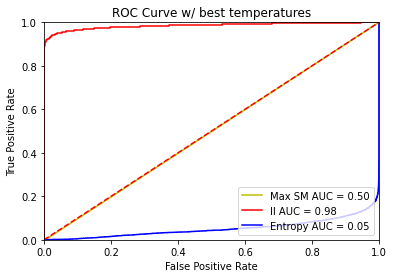

In [56]:
# ROC curve on validation data with single model no adv training
# max_SM?
# validation set?
calc_plot_roc('single_no_at')

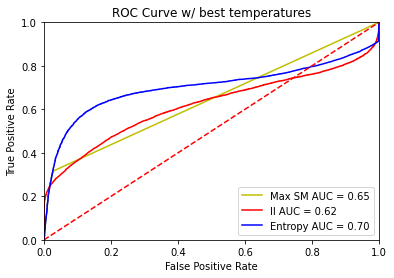

In [57]:
# ROC curve on test data with single model no adv training
# Check how the adv entropy is distributed
calc_plot_roc('single_no_at_test')

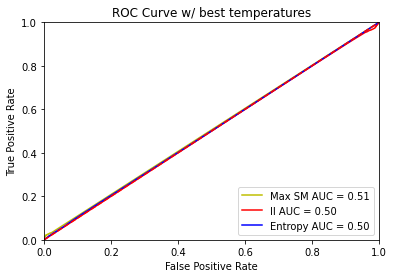

In [58]:
# ROC curve on validation data with single model with adv training
# validation data
calc_plot_roc('single_at')

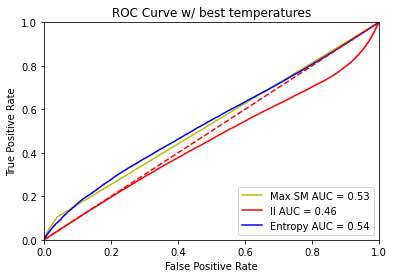

In [59]:
# ROC curve on test data with single model with adv training
calc_plot_roc('single_at_test')

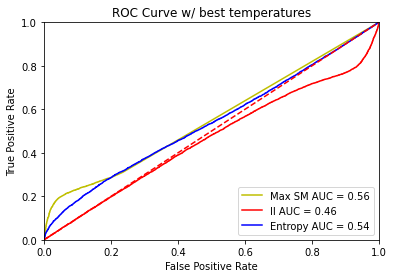

In [93]:
calc_plot_roc("normal.json")

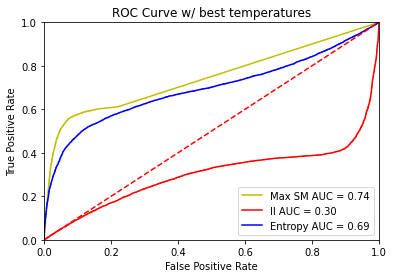

In [95]:
# low accuracy
calc_plot_roc("4transforms.json")

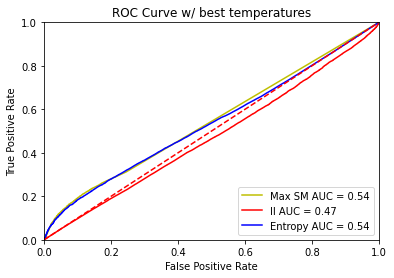

In [60]:
# ROC curve on validation data with ensemble model with adv training
calc_plot_roc('ensemble_at', True)

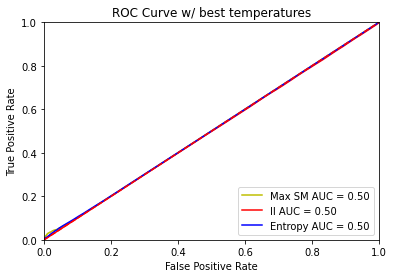

In [102]:
#?
calc_plot_roc("PGD-ensemble-3.json", True)

(4, 20000, 10)
(4, 20000, 10)
(4, 20000, 10)


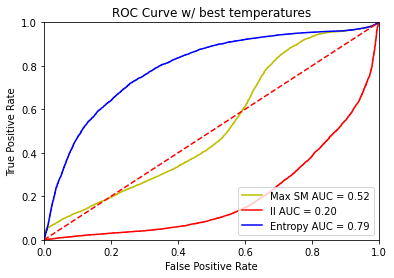

In [113]:
calc_plot_roc("ensemble_single_trans.json", True)

In [121]:
np.array(split_correct(test_outputs["ensemble_single_trans.json"]['adv'], 1, y_test, ensemble=True)['correct_logits']).shape

(4, 4810, 10)

In [122]:
np.array(split_correct(test_outputs["ensemble_single_trans.json"]['adv'], 1, y_test, ensemble=True)['incorrect_logits']).shape

(4, 5190, 10)

In [124]:
4810/(4810+5190)*100

48.1

In [126]:
np.array(split_correct(test_outputs["normal.json"]['adv'], 1, y_test)['correct_logits']).shape

(8041, 10)

In [127]:
np.array(split_correct(test_outputs["normal.json"]['adv'], 1, y_test)['incorrect_logits']).shape

(1959, 10)

In [ ]:
np.array(split_correct(test_outputs["normal.json"]['adv'], 1, y_test)['correct_logits']).shape

## Correct vs incorrect in clean/adv combined

In [80]:
MNIST_ENSEMBLE = {}
MNIST_ENSEMBLE['clean']= split_correct(test_outputs["PGD-ensemble-3.json"]['clean'], 1, y_test, ensemble=True)
MNIST_ENSEMBLE['adv']= split_correct(test_outputs["PGD-ensemble-3.json"]['adv'], 1, y_test, ensemble=True)

## Correct vs incorrect in clean samples

## Correct vs incorrect in adv samples